In [9]:
!pip install xeno-canto

In [16]:
# Download only the metadata
import json

!xeno-canto -m grp:"bats" q:"A"

# Uncomment the next line to get all data (WARNING 10 GiB)
# !xeno-canto -dl grp:"bats" q:"A"

dir = "dataset/metadata/grp_batsq_A"

with open(dir+"/page1.json", 'r') as file:
    data = json.load(file)
    print("API message:", data["message"])
    print("Number of recordings:", data["numRecordings"])
    print("Number of pages:", data["numPages"])

API message: Xeno-canto API v2 will be phased out on October 10, 2025. Visit https://xeno-canto.org/explore/api for API v3 documentation.
Number of recordings: 1171
Number of pages: 3


In [62]:
import os
import json
import pandas as pd

# Convert metadata into frames
frames = []
for entry in os.scandir(dir):
    if entry.is_file():
        with open(entry, 'r') as file:
            data = json.load(file)
            df = pd.DataFrame(data['recordings'])
            frames.append(df)

all_data = pd.concat(frames)

# Print some metadata
print (all_data.columns.values.tolist())


# all_data.head()

# print(all_data)


['id', 'gen', 'sp', 'ssp', 'group', 'en', 'rec', 'cnt', 'loc', 'lat', 'lng', 'alt', 'type', 'sex', 'stage', 'method', 'url', 'file', 'file-name', 'sono', 'osci', 'lic', 'q', 'length', 'time', 'date', 'uploaded', 'also', 'rmk', 'bird-seen', 'animal-seen', 'playback-used', 'temp', 'regnr', 'auto', 'dvc', 'mic', 'smp']


In [72]:
def to_seconds(x):
    mins, secs = map(float, x.split(':'))
    return mins * 60 + secs

all_data['length'] = all_data['length'].apply(to_seconds)
data = all_data[["id", "gen", "sp", "en", "cnt", "loc", "type", "sex", "length", "dvc", "mic"]]




<Axes: xlabel='length', ylabel='Count'>

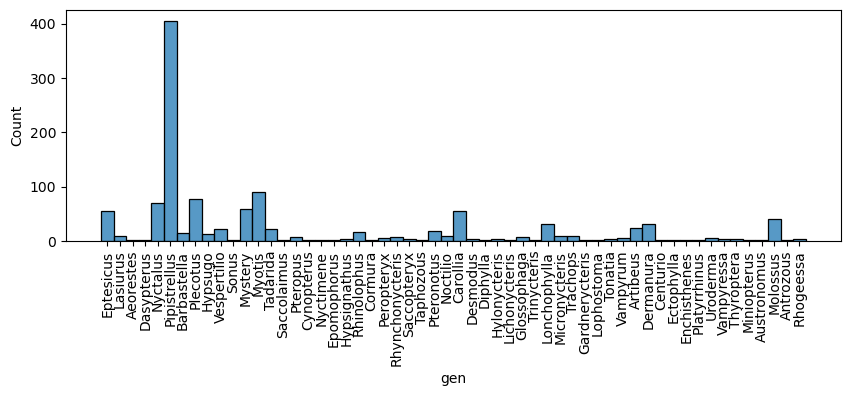

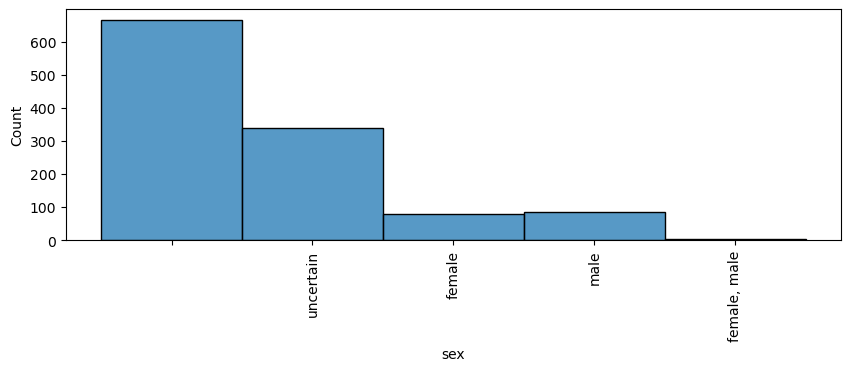

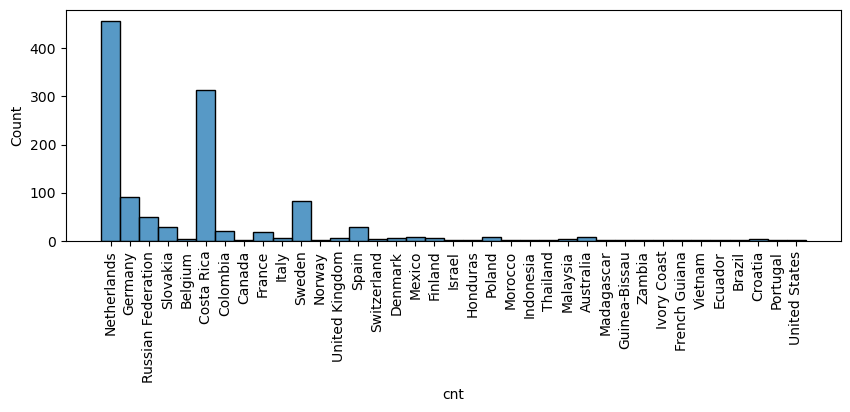

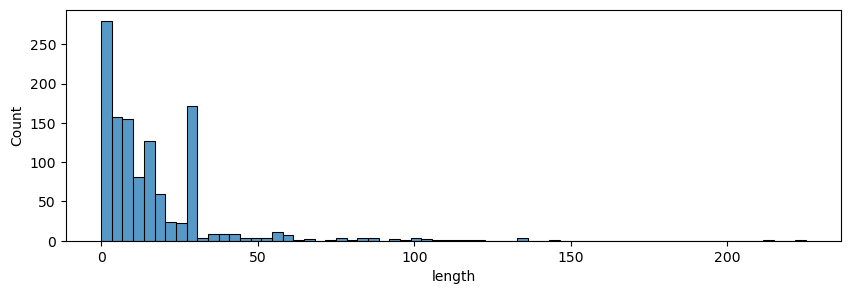

In [74]:
import matplotlib.pyplot as plt
import seaborn

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
seaborn.histplot(x="gen", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
seaborn.histplot(x="sex", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
seaborn.histplot(x="cnt", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
seaborn.histplot(x="length", data=data)